# Recurrent Neural Networks
---
# Predicting Stock Prices through an LSTM model

In [98]:
''' Linear Algebra '''
import pandas as pd
import numpy as np

'''Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [99]:
''' Handling timestamps'''
import datetime
from datetime import datetime

In [100]:
# url = 'https://raw.githubusercontent.com/timjab92/cryptotradingindicator/master/data/BTCUSD_4hours.csv'

# data = pd.read_csv(url)
# # Dataset is now stored in a Pandas Dataframe
# data = data.drop(columns="Unnamed: 0").set_index("date")

In [101]:
!pwd

/home/timjab92/code/timjab92/cryptotrading-indicator/notebooks


In [102]:
data = pd.read_csv("../data/BTC4h.csv")

In [103]:
def get_new_data():
    data = pd.read_csv("../data/BTC4h.csv")
    data['date'] = pd.to_datetime(data.date)
    data = data.set_index('date')
    return data

data = get_new_data()

In [104]:
CLOSE = 'log_close'

In [105]:
import requests
def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'close', 'volume']

    for x in ['open', 'high', 'low', 'close']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api


def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data[CLOSE])
    add_vol_roc(data)
    data['4h Return'] = data[CLOSE].pct_change()
    data['4h Gradient'] = data[CLOSE].diff()
    data['boll_width'] = data['bollinger_up'] - data['bollinger_down']
    data['stoch_rsi'] = (data['K'] + data['D']) / 2
    data['perc_bb'] = (data[CLOSE] - data['bollinger_down']) / (data['bollinger_up'] - data['bollinger_down'])

    return data

## add other features

def add_ema(data, tspan=[12,26,21,50,34,55,99,200]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data[CLOSE].ewm(span=t).mean()
        data[f'dist_ema{t}'] = data[CLOSE] - data[f'ema{t}']
    return data


def computeRSI(data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi


def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  


def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data[CLOSE], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data


def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down


def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    for i in ['bollinger_up', 'bollinger_down']:
        data[f'dist_{i}'] = data[CLOSE] - data[i]
    return data


def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data


In [106]:
def get_train_data():
    """
    Returns the raw training dataset for the price of bitcoin since 31.12.2011.
    The index is set to the date.
    """
    data = pd.read_csv("../data/BTCUSD_4hours.csv")
    data['date'] = pd.to_datetime(data.date)
    data_train = data.drop(columns="Unnamed: 0").set_index("date")
    return data_train


def minmaxscaling(data_train):
    """
    applies the minmaxscaler to the training set. Attention! Output needs to be
    defined for data_train_scaled, min1 and range1!!
    """
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))
    minmax_scaler.fit(data_train)
    data_train_scaled = minmax_scaler.transform(data_train)
    #    min1 = minmax_scaler.data_min_  # [5:9] for log_prices
    #    range1 = minmax_scaler.data_range_  #[5:9]
    return data_train_scaled, minmax_scaler


def get_xgecko(length=60, horizon=1):
    """
    Calls the coingecko API and returns the data used for prediction.
    x_gecko.shape == (no_sequ , length, no_features)
    """
    x_gecko = feature_engineer(get_coingecko())[[CLOSE]][-length:]
    #get scaler the long way
    data_train = feature_engineer(get_train_data())[[CLOSE]]
    data_train_scaled, scaler = minmaxscaling(data_train)

    x_gecko_scaled = scaler.transform(x_gecko)
    x_gecko = np.array(x_gecko_scaled)
    x_gecko = np.reshape(x_gecko, (horizon, length, 1))
    return x_gecko

### Daily return

$ return = \frac{new - old}{old} $

In [107]:
data = feature_engineer(data)

In [108]:
data = data.dropna()

In [109]:
data.head()

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,4h Return,4h Gradient,boll_width,stoch_rsi,perc_bb
date,,,,,,,,,,,,,,,,,,,,,
2015-10-13 20:00:00,250.35,250.42,250.00,250.42,4.212360,5.522860,5.523140,5.521461,5.523140,5.517817,...,5.529435,5.497779,-0.006295,0.025361,1.008111,0.000051,0.000280,0.031656,43.358767,0.801141
2015-10-14 00:00:00,250.42,251.08,250.42,251.00,13.965352,5.523140,5.525772,5.523140,5.525453,5.518997,...,5.530550,5.498932,-0.005097,0.026521,2.315327,0.000419,0.002313,0.031618,41.877594,0.838801
2015-10-14 04:00:00,251.00,251.00,250.70,251.00,12.449493,5.525453,5.525453,5.524257,5.525453,5.519993,...,5.531692,5.499680,-0.006239,0.025773,-0.108544,0.000000,0.000000,0.032012,43.412828,0.805103
2015-10-14 08:00:00,251.00,251.86,251.00,251.15,8.686492,5.525453,5.528873,5.525453,5.526050,5.520928,...,5.532699,5.500623,-0.006649,0.025428,-0.302261,0.000108,0.000597,0.032077,49.118346,0.792714
2015-10-14 12:00:00,251.15,253.00,251.15,253.00,2.049007,5.526050,5.533389,5.526050,5.533389,5.522850,...,5.534945,5.501061,-0.001556,0.032329,-0.764116,0.001328,0.007339,0.033885,59.940756,0.954085


## BITCOIN Price

In [110]:
df = pd.DataFrame(data['log_close']).copy()
df['t1'] = df.log_close.diff()
df['diff'] = df.log_close - df.t1

In [111]:
df.

SyntaxError: invalid syntax (791285630.py, line 1)

In [112]:
df.dropna(inplace=True)

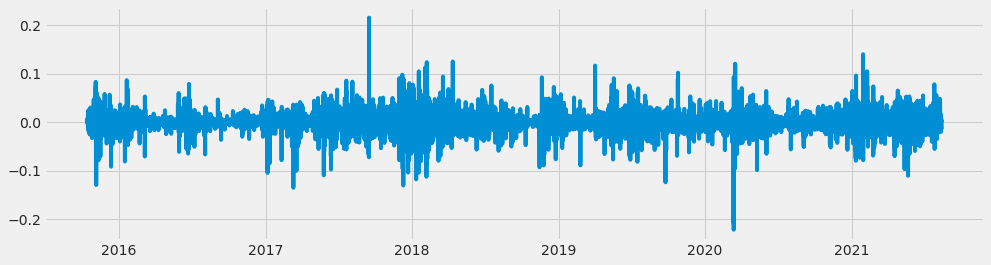

In [113]:
plt.figure(figsize=(15,4))
plt.plot(df['t1'])

In [114]:
import seaborn as sns

In [115]:
data.keys()

Index(['open', 'high', 'low', 'close', 'volume', 'log_open', 'log_high',
       'log_low', 'log_close', 'ema12', 'dist_ema12', 'ema26', 'dist_ema26',
       'ema21', 'dist_ema21', 'ema50', 'dist_ema50', 'ema34', 'dist_ema34',
       'ema55', 'dist_ema55', 'ema99', 'dist_ema99', 'ema200', 'dist_ema200',
       'rsi', 'K', 'D', 'sma', 'bollinger_up', 'bollinger_down',
       'dist_bollinger_up', 'dist_bollinger_down', 'vol_roc', '4h Return',
       '4h Gradient', 'boll_width', 'stoch_rsi', 'perc_bb'],
      dtype='object')

In [116]:
data.corr()

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,4h Return,4h Gradient,boll_width,stoch_rsi,perc_bb
open,1.000000,0.999861,0.999735,0.999701,-0.044233,0.770054,0.770039,0.769864,0.769972,0.769700,...,0.769038,0.769054,-0.106494,0.129352,-0.012639,-0.012805,-0.010607,0.172846,0.000564,-0.021310
high,0.999861,1.000000,0.999672,0.999855,-0.040998,0.769857,0.769960,0.769686,0.769874,0.769540,...,0.768976,0.768802,-0.107382,0.133206,-0.012612,-0.005775,-0.002402,0.176303,0.001219,-0.019001
low,0.999735,0.999672,1.000000,0.999797,-0.050336,0.770245,0.770249,0.770236,0.770283,0.769873,...,0.769057,0.769316,-0.099270,0.130620,-0.012702,-0.004367,-0.000700,0.168414,0.002553,-0.016086
close,0.999701,0.999855,0.999797,1.000000,-0.045093,0.770011,0.770095,0.769942,0.770125,0.769694,...,0.769019,0.769027,-0.102232,0.133902,-0.012656,0.000999,0.005607,0.172993,0.002142,-0.015462
volume,-0.044233,-0.040998,-0.050336,-0.045093,1.000000,0.072514,0.076088,0.066920,0.071933,0.073536,...,0.084780,0.063453,-0.333019,0.223420,-0.004715,-0.044240,-0.048514,0.409000,-0.025150,-0.056741
log_open,0.770054,0.769857,0.770245,0.770011,0.072514,1.000000,0.999886,0.999922,0.999927,0.999872,...,0.999275,0.999295,-0.152312,0.153892,-0.027953,-0.016566,-0.011000,0.224616,-0.015683,-0.057229
log_high,0.770039,0.769960,0.770249,0.770095,0.076088,0.999886,1.000000,0.999816,0.999889,0.999785,...,0.999292,0.999104,-0.153690,0.157725,-0.027966,-0.010376,-0.004747,0.228421,-0.015002,-0.055214
log_low,0.769864,0.769686,0.770236,0.769942,0.066920,0.999922,0.999816,1.000000,0.999944,0.999784,...,0.999041,0.999308,-0.146078,0.153972,-0.028061,-0.008756,-0.003161,0.220055,-0.014143,-0.053174
log_close,0.769972,0.769874,0.770283,0.770125,0.071933,0.999927,0.999889,0.999944,1.000000,0.999824,...,0.999216,0.999230,-0.149042,0.157354,-0.028013,-0.004687,0.001059,0.224707,-0.014267,-0.052536
ema12,0.769700,0.769540,0.769873,0.769694,0.073536,0.999872,0.999785,0.999784,0.999824,1.000000,...,0.999568,0.999573,-0.162194,0.144261,-0.027932,-0.014531,-0.008943,0.224943,-0.024460,-0.067538


In [117]:
# TIME = 10000
# data = data[TIME:]

In [118]:
#selected_features=[CLOSE,'log_high', 'bollinger_up', 'rsi']
#21,99 emas
#selected_features=[CLOSE,'log_high','rsi','ema34', '4h Return','bollinger_up']
selected_features = [CLOSE, 'open','dist_ema99', 'stoch_rsi', 'boll_width']

In [119]:
selected_data = data[selected_features]
#selected_data['diff'] = selected_data.log_close.diff()
#selected_data.dropna(inplace=True)
selected_data

,log_close,open,dist_ema99,stoch_rsi,boll_width
date,,,,,
2015-10-13 20:00:00,5.523140,250.35,0.013470,43.358767,0.031656
2015-10-14 00:00:00,5.525453,250.42,0.015135,41.877594,0.031618
2015-10-14 04:00:00,5.525453,251.00,0.014526,43.412828,0.032012
2015-10-14 08:00:00,5.526050,251.00,0.014526,49.118346,0.032077
2015-10-14 12:00:00,5.533389,251.15,0.021019,59.940756,0.033885
...,...,...,...,...,...
2021-08-12 04:00:00,10.720834,45948.06,0.092495,13.870354,0.067658
2021-08-12 08:00:00,10.709046,45289.65,0.079093,9.101978,0.054715
2021-08-12 12:00:00,10.696573,44758.93,0.065287,2.068711,0.050001


<AxesSubplot:>

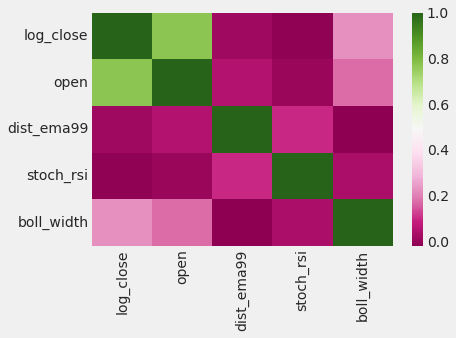

In [120]:
sns.heatmap(selected_data.corr(),cmap="PiYG")

In [121]:
len(selected_data)

12775

In [122]:
np.array(selected_data)[1][0]

5.525452939131784

In [123]:
selected_data

,log_close,open,dist_ema99,stoch_rsi,boll_width
date,,,,,
2015-10-13 20:00:00,5.523140,250.35,0.013470,43.358767,0.031656
2015-10-14 00:00:00,5.525453,250.42,0.015135,41.877594,0.031618
2015-10-14 04:00:00,5.525453,251.00,0.014526,43.412828,0.032012
2015-10-14 08:00:00,5.526050,251.00,0.014526,49.118346,0.032077
2015-10-14 12:00:00,5.533389,251.15,0.021019,59.940756,0.033885
...,...,...,...,...,...
2021-08-12 04:00:00,10.720834,45948.06,0.092495,13.870354,0.067658
2021-08-12 08:00:00,10.709046,45289.65,0.079093,9.101978,0.054715
2021-08-12 12:00:00,10.696573,44758.93,0.065287,2.068711,0.050001


### Temporal Train-Test Split

In [124]:
train_percentage = 95

In [125]:
train_len = int(len(selected_data) * train_percentage/100)
train_len

12136

In [126]:
data_train = selected_data[:train_len]
data_test = selected_data[train_len:]

## LSTM

In [127]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler(feature_range = (0,1))

minmax_scaler.fit(data_train)

data_train_scaled = minmax_scaler.transform(data_train)
data_test_scaled = minmax_scaler.transform(data_test)

In [128]:
minmax_scaler.data_max_

array([1.10754626e+01, 6.45672500e+04, 4.86491069e-01, 1.00000000e+02,
       7.32623472e-01])

In [129]:
minmax_scaler.data_min_

array([ 5.52313951e+00,  2.50350000e+02, -5.46251843e-01,  0.00000000e+00,
        4.58400179e-03])

In [130]:
min1 = minmax_scaler.data_min_[0]
min1

5.523139508240802

In [131]:
range1 = minmax_scaler.data_range_[0]
range1

5.552323087034936

In [132]:
data_train_scaled[:]

array([[0.00000000e+00, 0.00000000e+00, 5.41976113e-01, 4.33587673e-01,
        3.71848278e-02],
       [4.16659992e-04, 1.08836091e-06, 5.43588029e-01, 4.18775943e-01,
        3.71320644e-02],
       [4.16659992e-04, 1.01062085e-05, 5.42998128e-01, 4.34128277e-01,
        3.76737369e-02],
       ...,
       [9.70733131e-01, 8.52548086e-01, 5.27353271e-01, 9.34144941e-01,
        2.36057171e-01],
       [9.68898097e-01, 8.49433042e-01, 5.17716509e-01, 7.82654725e-01,
        2.31190107e-01],
       [9.70825681e-01, 8.40782905e-01, 5.28096821e-01, 6.42943751e-01,
        2.22847233e-01]])

### Creating subsequences...

In [133]:
window_size = 36#36  # test with small window size         #60
horizon = 1 #number of predictions into the future :) 
data_train_subsequences = []
fake_y_train = []
for k in range(len(data_train_scaled)-(window_size-1)-horizon):
    data_train_subsequences.append(data_train_scaled[k:k+window_size])
    fake_y_train.append(data_train_scaled[k+window_size:k+window_size+horizon]) #add [0] for log_price to be predicted

In [134]:
np.array(fake_y_train).shape

(12100, 1, 5)

In [135]:
np.array(data_train_subsequences).shape

(12100, 36, 5)

In [136]:
X_train = np.array(data_train_subsequences) #[:,:,1:]
y_train = np.array(fake_y_train)[:,:,0] #.reshape(-1,1)

In [137]:
X_train.shape

(12100, 36, 5)

In [138]:
y_train.shape

(12100, 1)

In [139]:
#with the same window_size & horizon as the train data
data_test_subsequences = []
fake_y_test = []
for k in range(len(data_test_scaled)-(window_size-1)-horizon):
    data_test_subsequences.append(data_test_scaled[k:k+window_size])
    fake_y_test.append(data_test_scaled[k+window_size:k+window_size+horizon])

In [140]:
X_test = np.array(data_test_subsequences) #[:,:,1:]
y_test = np.array(fake_y_test)[:,:,0] #.reshape(-1,1)

In [141]:
X_test.shape

(603, 36, 5)

In [142]:
y_test.shape

(603, 1)

### LSTM

#### RNN Architecture

In [143]:
pd.DataFrame(y_test).shape

(603, 1)

In [144]:
from tensorflow.keras import metrics

my_mae = metrics.MeanAbsoluteError(
    name='mean_absolute_error', dtype=None
)


In [145]:
from tensorflow.keras import Sequential, layers

# Build the LSTM model
model = Sequential()

model.add(layers.LSTM(units=128,
                     return_sequences = True,
                     activation = "tanh"
                    #activation = "relu"
                     #input_shape = X_train[0].shape)
                     ))
model.add(layers.Dropout(rate=0.2))

model.add(layers.LSTM(units=256,
                      return_sequences = False,
                      activation = "relu"  
                    #activation = "relu"
                     ))
#model.add(layers.Dropout(rate=0.05))
# model.add(layers.Dense(25,
#                          activation="relu"))
model.add(layers.Dense(32,
                        activation = "tanh" 
                       #activation="relu"
                      ))

#model.add(layers.Dense(32,activation="relu"))
#model.add(layers.Dense(16,
#                       activation = "relu"
                       #activation="relu"
#                      ))
#model.add(layers.Dense(8,activation="relu"))

model.add(layers.Dense(1,
                      activation = "relu" 
                      #activation="relu"
                      ))

#model.summary()



In [146]:
# from tensorflow.keras import Sequential, layers

# # Build the LSTM model
# model = Sequential()

# model.add(layers.LSTM(units=128,
#                      return_sequences = True,
#                      activation = "tanh"
#                     #activation = "relu"
#                      #input_shape = X_train[0].shape)
#                      ))

# model.add(layers.LSTM(units=64,
#                       return_sequences = False,
#                       activation = "relu"  
#                     #activation = "relu"
#                      ))

# # model.add(layers.Dense(25,
# #                          activation="relu"))
# model.add(layers.Dense(32,
#                         activation = "tanh" 
#                        #activation="relu"
#                       ))
# #model.add(layers.Dense(16,activation="relu"))
# model.add(layers.Dense(8,
#                        activation = "relu"
#                        #activation="relu"
#                       ))
# model.add(layers.Dense(4,
#                       activation = "relu" 
#                       #activation="relu"
#                       ))

# #model.summary()



In [147]:
model.compile(loss="mse",
             optimizer = "adam",#rmsprop
             metrics = "mae"#[my_mae]
             )

#### Training

In [148]:
#### perhaps create a validation and train sets by hand

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping 

es = EarlyStopping(patience = 5, 
                   restore_best_weights= True,
                   monitor = "mae"
                  )

history = model.fit(X_train, y_train,
          validation_split = 0.2,
         batch_size=16,
         epochs=30,
         verbose = 1,
         callbacks = [es]
                   )

Epoch 1/30
605/605 [==============================] - 29s 46ms/step - loss: 0.0017 - mae: 0.0178 - val_loss: 8.9124e-04 - val_mae: 0.0215
Epoch 2/30
605/605 [==============================] - 30s 49ms/step - loss: 1.6410e-04 - mae: 0.0099 - val_loss: 0.0013 - val_mae: 0.0218
Epoch 3/30
605/605 [==============================] - 31s 52ms/step - loss: 1.2777e-04 - mae: 0.0087 - val_loss: 5.2745e-04 - val_mae: 0.0150
Epoch 4/30
605/605 [==============================] - 32s 53ms/step - loss: 1.3903e-04 - mae: 0.0091 - val_loss: 6.7917e-04 - val_mae: 0.0158
Epoch 5/30
605/605 [==============================] - 33s 54ms/step - loss: 1.0524e-04 - mae: 0.0079 - val_loss: 2.4584e-04 - val_mae: 0.0129
Epoch 6/30
605/605 [==============================] - 33s 55ms/step - loss: 9.5342e-05 - mae: 0.0075 - val_loss: 5.1888e-04 - val_mae: 0.0141
Epoch 7/30
605/605 [==============================] - 33s 55ms/step - loss: 8.7187e-05 - mae: 0.0072 - val_loss: 3.4147e-04 - val_mae: 0.0171
Epoch 8/30
605

In [ ]:
def plot_loss_mae(history):
    
    fig, ax =plt.subplots(1,2,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
#     # --- MAE

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('Model MAE', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)   
    
    plt.show()
    

In [ ]:
plot_loss_mae(history)

#### Evaluating

In [ ]:
res = model.evaluate(X_test, np.array(y_test), verbose = 1)
res


In [71]:
data['baseline'] = data['close'].shift()
df = data[['close', 'baseline']]
mae_base = np.mean(np.abs(df['close'] - df['baseline']))

#### Predictions

In [72]:
predictions = model.predict(X_test)

In [73]:
len(predictions), len(y_test)

(621, 621)

In [74]:
predictions[0:3]

array([[0.9598886],
       [0.9574633],
       [0.9595625]], dtype=float32)

In [75]:
y_test_unscaled = y_test * range1 + min1

In [76]:
predictions_unscaled = predictions * range1 + min1

In [77]:
predictions_unscaled[0:3]

array([[10.852751],
       [10.839285],
       [10.850941]], dtype=float32)

The operation computed during a `MinMaxScaler` Operation is:

$$x_{scaled} = \frac{x - x_{min}}{x_{max}- x_{min}}$$

To descale it:

$$x = x_{scaled} * (x_{max}- x_{min}) + x_{min}$$

Or use the `inverse_transform` directly provided...

In [78]:
X_test.shape

(621, 18, 5)

In [79]:
predictions.shape

(621, 1)

In [80]:
pred = pd.DataFrame(predictions_unscaled, columns = ['pred_1']) #,'pred_2','pred_3''pred_4','pred_5','pred_6'
test = pd.DataFrame(y_test_unscaled, columns = ['test_1']) #,,'test_2','test_3', 'test_4','test_5','test_6'
result = pd.concat([pred, test], axis=1)

In [81]:
result

,pred_1,test_1
0,10.852751,10.958271
1,10.839285,10.965592
2,10.850941,10.965944
3,10.841064,10.942835
4,10.817517,10.945397
...,...,...
616,10.641041,10.720834
617,10.611454,10.709046
618,10.611378,10.696573
619,10.591524,10.701154


In [82]:
for i in range(1,2):
    result[f'weight_{i}'] = np.mean(result[f'test_{i}'] - result[f'pred_{i}'])

In [83]:
result

,pred_1,test_1,weight_1
0,10.852751,10.958271,0.067353
1,10.839285,10.965592,0.067353
2,10.850941,10.965944,0.067353
3,10.841064,10.942835,0.067353
4,10.817517,10.945397,0.067353
...,...,...,...
616,10.641041,10.720834,0.067353
617,10.611454,10.709046,0.067353
618,10.611378,10.696573,0.067353
619,10.591524,10.701154,0.067353


In [84]:
for i in range(1,2):
    result[f'pred_weight_{i}'] = result[f'pred_{i}'] + result[f'weight_{i}']

In [85]:
result

,pred_1,test_1,weight_1,pred_weight_1
0,10.852751,10.958271,0.067353,10.920104
1,10.839285,10.965592,0.067353,10.906638
2,10.850941,10.965944,0.067353,10.918294
3,10.841064,10.942835,0.067353,10.908418
4,10.817517,10.945397,0.067353,10.884871
...,...,...,...,...
616,10.641041,10.720834,0.067353,10.708394
617,10.611454,10.709046,0.067353,10.678807
618,10.611378,10.696573,0.067353,10.678731
619,10.591524,10.701154,0.067353,10.658878


In [86]:
# for col in ['pred_1','pred_2','pred_3','test_1','test_2','test_3']

In [87]:
# mae_1 = np.mean(np.abs(result['test_1'] - result['pred_1']))
# mae_2 = np.mean(np.abs(result['test_2'] - result['pred_2']))
# mae_3 = np.mean(np.abs(result['test_3'] - result['pred_3']))
# #mae_4 = np.mean(np.abs(result['test_4'] - result['pred_4']))

In [88]:
# #log_data
mae_1 = np.mean(np.abs(np.exp(result['test_1']) - np.exp(result['pred_1'])))
#mae_2 = np.mean(np.abs(np.exp(result['test_2']) - np.exp(result['pred_2'])))
#mae_3 = np.mean(np.abs(np.exp(result['test_3']) - np.exp(result['pred_3'])))
#mae_4 = np.mean(np.abs(np.exp(result['test_4']) - np.exp(result['pred_4'])))
# # #mae_5 = np.mean(np.abs(np.exp(result['test_5']) - np.exp(result['pred_5'])))
# # #mae_6 = np.mean(np.abs(np.exp(result['test_6']) - np.exp(result['pred_6'])))

In [89]:
# np.exp(result['weight_1'].mean())

In [90]:
print(mae_1)
print(mae_2)
print(mae_3)
#print(mae_4)

2756.959953074666


NameError: name 'mae_2' is not defined

In [91]:
np.mean([mae_1,mae_2,mae_3])

NameError: name 'mae_2' is not defined

In [92]:
mae = np.mean(np.abs(y_test_unscaled[:,0] - predictions_unscaled[:,0]))
mae

0.06794962024235796

In [93]:
np.mean(np.abs((y_test_unscaled - predictions_unscaled) / y_test_unscaled)) *100

0.6390393773747365

In [94]:
# df =pd.DataFrame()
# df['y_test'] = pd.DataFrame(y_test_unscaled).apply(lambda x: np.exp(x))
# df['pred'] = pd.DataFrame(predictions_unscaled).apply(lambda x: np.exp(x))
# df['diff'] = df['y_test'] - df['pred']

In [95]:
# np.mean(np.abs(df['diff']))

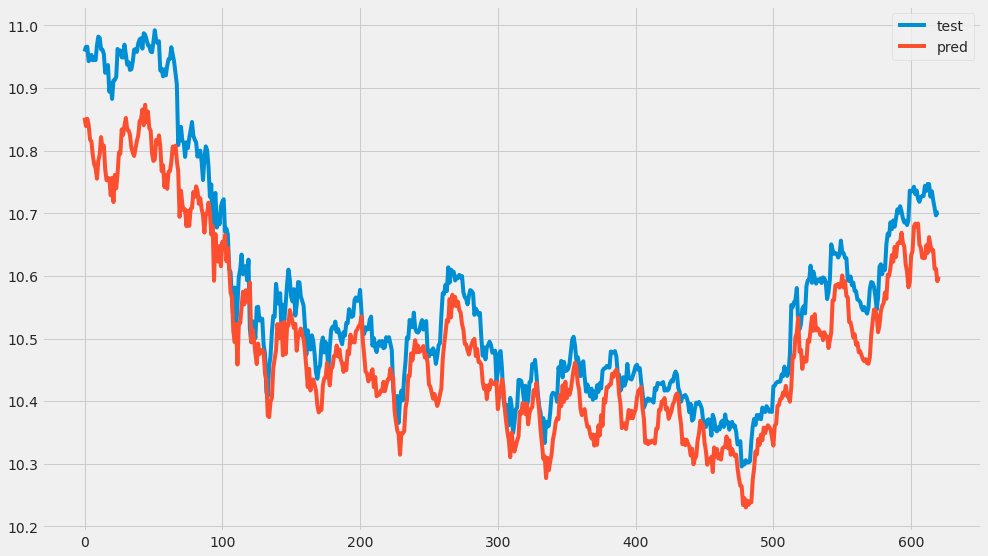

In [96]:
plt.figure(figsize=(15,9))
plt.plot(result[['test_1', 'pred_1']][:], label=["test", "pred"])
plt.legend()                                      #timehorizon here
plt.show()


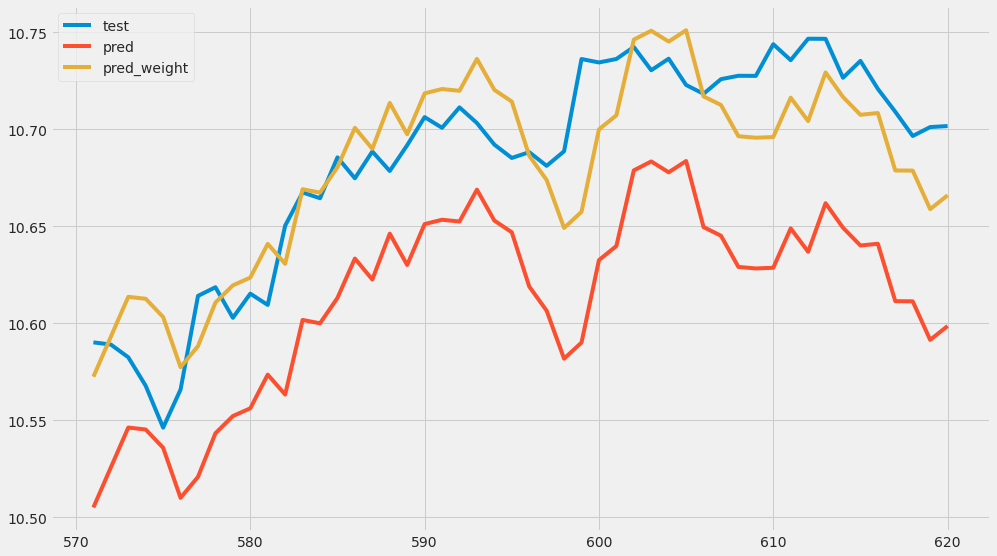

In [97]:
plt.figure(figsize=(15,9))
plt.plot(result[['test_1', 'pred_1', 'pred_weight_1']][-50:], label=["test", "pred", "pred_weight"])
plt.legend()                                      #timehorizon here
plt.show()


In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,15))
axs[0,0].plot(result[['test_1', 'pred_1', 'pred_weight_1']][-100:], label=["test", "pred", "pred_weight"])
axs[0,1].plot(result[['test_2', 'pred_2', 'pred_weight_2']][-100:], label=["test", "pred", "pred_weight"])
axs[1,0].plot(result[['test_3', 'pred_3', 'pred_weight_3']][-100:], label=["test", "pred", "pred_weight"])
#axs[1,1].plot(result[['test_4', 'pred_4', 'pred_weight_4']][-100:], label=["test", "pred", "pred_weight"])

plt.legend()
plt.show()


# PREDICTION WITH COINGECKO!!!

In [ ]:
gecko_api = get_coingecko()

In [ ]:
coingecko = feature_engineer(gecko_api)
coingecko['perc_bb'] = (coingecko.log_close - coingecko.bollinger_down) / (coingecko.bollinger_up - coingecko.bollinger_down)
coingecko = coingecko[selected_features][-160:-1]

In [ ]:
x_gecko_scaled = minmax_scaler.transform(coingecko)

In [ ]:
# x_gecko_subsequences = []
# for k in range(len(x_gecko_scaled)-(window_size-1)-horizon):
#     x_gecko_subsequences.append(x_gecko_scaled[k:k+window_size])

In [ ]:
# x_gecko = np.array(x_gecko_subsequences)

In [ ]:
x_gecko_scaled.shape

In [ ]:
x_gecko = x_gecko_scaled[-window_size:]

In [ ]:
x_gecko.shape

In [ ]:
x_gecko = np.array(x_gecko).reshape(-1,window_size,len(selected_features))

In [ ]:
x_gecko.shape

In [ ]:
pred_gecko = model.predict(x_gecko)

In [ ]:
pred_gecko

In [ ]:
pred_gecko_unscaled = pred_gecko * range1 + min1

In [ ]:
pred_gecko_unscaled

In [ ]:
#weighted prediction

In [ ]:
weighted_pred = []
for i in range(0,1):
    weighted_pred.append(pred_gecko_unscaled[0][i] + result[f'weight_{i+1}'].mean())

In [ ]:
#log
# weighted_pred = []
# for i in range(0,4):
#     weighted_pred.append(np.exp(pred_gecko_unscaled[0][i] + result[f'weight_{i+1}'].mean()))

In [ ]:
weighted_pred

In [ ]:
#add mae
mae_1
mae_2
mae_3
#mae_4

In [ ]:
mae_list = [mae_1, mae_2, mae_3]
preds = list(pred_gecko_unscaled[0])

In [ ]:
#log
# mae_list = [mae_1, mae_2, mae_3, mae_4]
# preds = list(np.exp(pred_gecko_unscaled[0]))

In [ ]:
preds_with_mae = [a+b for a,b in zip(mae_list, preds)]

In [ ]:
preds_with_mae

In [ ]:
#pred_weighted = pred_gecko_unscaled[0][0] + weight

In [ ]:
#np.exp(pred_weighted)

In [ ]:
np.exp(pred_gecko_unscaled)

In [ ]:
##########

In [ ]:
pred_weighted = pred_gecko_unscaled + weight

In [ ]:
df = coingecko[[CLOSE]].reset_index(drop=True) #.apply(lambda x: np.exp(x))

In [ ]:
#df1 = pd.DataFrame(pred_gecko_unscaled.reshape(4,1),columns=[CLOSE]).apply(lambda x: np.exp(x))

In [ ]:
#df1 = pd.DataFrame(weighted_pred.reshape(4,1),columns=[CLOSE]).apply(lambda x: np.exp(x))

In [ ]:
df1 = pd.DataFrame(np.array(weighted_pred).reshape(1,1),columns=[CLOSE])

In [ ]:
#df1 = pd.DataFrame(np.array(preds_with_mae).reshape(4,1),columns=[CLOSE])

In [ ]:
df2 = pd.concat([df,df1],axis=0).reset_index(drop=True)#.apply(lambda x: np.exp(x))
df2

In [ ]:
plt.plot(df2[120:159])
plt.plot(df2[158:])


In [ ]:
!pwd

In [ ]:
from tensorflow.keras.models import save_model
save_model(model, '../../tensorflowmodel')#,save_traces=False

In [ ]:
coingecko['baseline'] = coingecko['close'].shift()
df = coingecko[['close', 'baseline']]
mae_base = np.mean(np.abs(df['close'] - df['baseline']))

In [ ]:
mae_base

In [ ]:
mape_base = np.mean(np.abs((df['close'] - df['baseline']) / df['close'])) *100

In [ ]:
mape_base

In [ ]:
np.mean(np.abs((y_test_unscaled - predictions_unscaled) / y_test_unscaled)) *100

In [ ]:
x_gecko_scaled
x_gecko_subsequences = []
for k in range(len(x_gecko_scaled)-(window_size-1)-horizon):
    x_gecko_subsequences.append(x_gecko_scaled[k:k+window_size])

In [ ]:
#x_gecko = np.array(x_gecko)
x_gecko = np.reshape(x_gecko, (-1,window_size,len(selected_features))) #[-horizon:,:,:]

x_gecko.shape

In [ ]:
predictions = model.predict(x_gecko)

predictions

In [ ]:
predictions_unscaled = predictions * range1 + min1

In [ ]:
#np.exp(predictions_unscaled)

In [ ]:
from datetime import datetime
dateTimeObj = datetime.now()
print(dateTimeObj)

In [ ]:
close = pd.DataFrame(coingecko.close[-10:].reset_index().drop(columns='index'))

In [ ]:
close

In [ ]:
for i in range(len(close),len(close) + horizon):
    print(i)

In [ ]:
pred = pd.DataFrame(np.exp(predictions_unscaled), columns = ['close']).set_index(pd.Index(range(len(close),len(close) + horizon)))

In [ ]:
df = pd.DataFrame(np.exp(predictions_unscaled), columns = ['pred'])
df['gecko'] = coingecko['log_close']
df

In [ ]:
plt.plot(close)
plt.plot(pred)

In [ ]:
plt.plot(coingecko['close'][-20:])
plt.plot(predictions_unscaled)

In [ ]:
#from tensorflow.keras.models import save_model
#save_model(model, 'tensorflowmodel')